### Importing required libraries

In [2]:
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.metrics import Precision, Recall, Accuracy
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# config = ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.5
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

### Declaring the Image size and Batch size

In [3]:
IMAGE_SIZE = [256, 256]
BATCH_SIZE=16
image_dir='/content/drive/MyDrive/Project_2/BLACK_WHITE'

In [4]:
classes=["1-1","1-2","1-4","PURE"]

In [5]:
logdir='/content/drive/MyDrive/Project_2/CNN_Model_Related/Logs'

In [6]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

### Fetching and Preprocessing the image files

In [7]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [8]:
# Make sure you provide the same target size as initialied for the image size

training_set =tf.keras.utils.image_dataset_from_directory(
  image_dir,
  label_mode='int',
  validation_split=0.2,
  subset='training',
  seed=131,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

Found 2240 files belonging to 4 classes.
Using 1792 files for training.


In [9]:
# Make sure you provide the same target size as initialied for the image size

test_set = tf.keras.utils.image_dataset_from_directory(
  image_dir,
  label_mode='int',
  validation_split=0.2,
  subset='validation',
  seed=131,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

Found 2240 files belonging to 4 classes.
Using 448 files for validation.


In [ ]:
normalized_training_set = training_set.map(lambda x, y: (normalization_layer(x), y))
normalized_test_set=test_set.map(lambda x,y: (normalization_layer(x), y))

# image_batch, labels_batch = next(iter(normalized_training_set))      #<-----the data is fethched in this form: image batch, label batch

### Building the CNN Model

In [89]:
model=Sequential()

In [90]:
model.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())


model.add(Conv2D(128, (3,3), 1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Dropout(0.2))
model.add(Flatten())
# model.add(Dropout(0.1))

model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='sigmoid'))

In [91]:
# Summary of the model

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 30, 30, 64)      

In [92]:
# States the cost and optimization methods to use

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

### Training the model

In [93]:
r = model.fit(
    normalized_training_set,
    validation_data=normalized_test_set,
    epochs=25,
    steps_per_epoch=len(normalized_training_set),
    validation_steps=len(normalized_test_set),
    callbacks=[tensorboard_callback]
)

Epoch 1/25
112/112 [==============================] - 11s 79ms/step - loss: 0.5529 - accuracy: 0.7561 - val_loss: 0.6632 - val_accuracy: 0.6741
Epoch 2/25
112/112 [==============================] - 8s 70ms/step - loss: 0.4017 - accuracy: 0.8371 - val_loss: 0.5024 - val_accuracy: 0.8013
Epoch 3/25
112/112 [==============================] - 8s 65ms/step - loss: 0.3852 - accuracy: 0.8460 - val_loss: 0.3452 - val_accuracy: 0.8549
Epoch 4/25
112/112 [==============================] - 10s 91ms/step - loss: 0.3797 - accuracy: 0.8398 - val_loss: 0.4732 - val_accuracy: 0.7478
Epoch 5/25
112/112 [==============================] - 10s 84ms/step - loss: 0.3329 - accuracy: 0.8728 - val_loss: 0.3860 - val_accuracy: 0.8304
Epoch 6/25
112/112 [==============================] - 9s 77ms/step - loss: 0.2822 - accuracy: 0.8850 - val_loss: 0.2813 - val_accuracy: 0.8929
Epoch 7/25
112/112 [==============================] - 9s 78ms/step - loss: 0.2760 - accuracy: 0.8839 - val_loss: 0.2312 - val_accuracy: 0.9

### Plotting the performance of the model

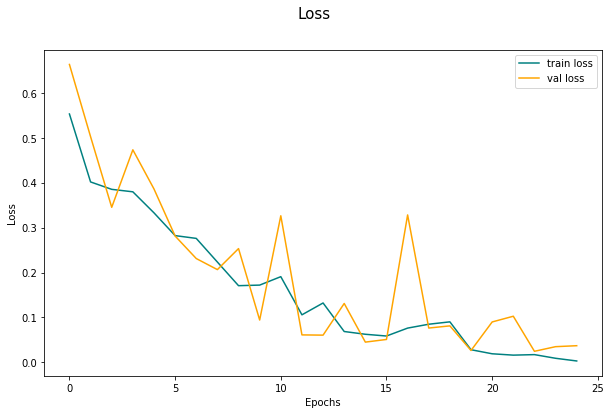

In [94]:
# Plotting the loss


fig=plt.figure(figsize=(10,6));
plt.plot(r.history['loss'], color='teal', label='train loss')
plt.plot(r.history['val_loss'], color='orange', label='val loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
fig.suptitle('Loss',fontsize=15)
plt.legend()
plt.show()

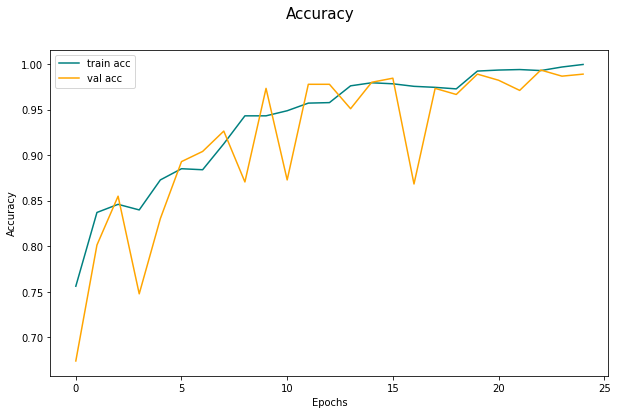

In [95]:
# Plotting the accuracy


fig=plt.figure(figsize=(10,6));
plt.plot(r.history['accuracy'], color='teal', label='train acc')
plt.plot(r.history['val_accuracy'], color='orange', label='val acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
fig.suptitle('Accuracy',fontsize=15)
plt.legend()
plt.show()

In [96]:
pre = Precision()
re = Recall()
acc = Accuracy()

In [97]:
y_true=[]
y_pred=[]
for images,labels in (normalized_test_set):
  for it in range(len(labels)):
    y_true.append(labels[it])
  pred=model.predict(images)
  y_max=[]
  for it in range(len(pred)):
      y_max.append(np.argmax(pred[it]))
      y_pred.append(np.argmax(pred[it]))
  pre.update_state(labels,y_max)
  re.update_state(labels,y_max)
  acc.update_state(labels,y_max)

1/1 [==============================] - 0s 26ms/step


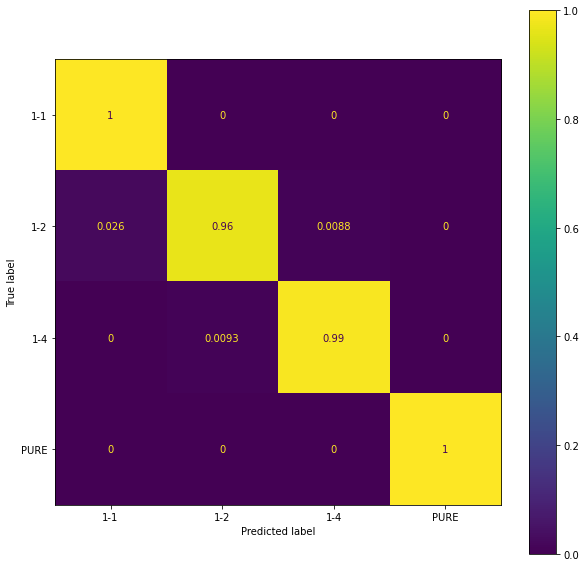

In [98]:
confusion_matrix=metrics.confusion_matrix(y_true,y_pred,normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['1-1', '1-2','1-4','PURE'])
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
plt.show();

In [99]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 1.0, Recall: 0.9910447597503662, Accuracy: 0.9888392686843872


### Saving the model

In [100]:
# Saving it as a h5 file

model.save('/content/drive/MyDrive/Project_2/CNN_Model_Related/Model/My_CNN_Model.h5')

### Loading the model and testing

In [101]:
model=load_model('/content/drive/MyDrive/Project_2/CNN_Model_Related/Model/My_CNN_Model.h5')

In [102]:
img=image.load_img('/content/drive/MyDrive/Project_2/BLACK_WHITE/1-4/CR_B_DU_1-4_013.jpg',target_size=(256,256))

In [103]:
x=image.img_to_array(img)

In [104]:
x=x/255
# x.shape

In [105]:
x=np.expand_dims(x,axis=0)
x.shape

(1, 256, 256, 3)

In [106]:
pred=model.predict(x)

1/1 [==============================] - 0s 86ms/step


In [107]:
print(pred)

[[6.4612671e-08 9.3214500e-01 1.0000000e+00 4.6518167e-12]]


In [108]:
pred_name = classes[np.argmax(pred)]
print(pred_name)

1-4
